In [ ]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/DS8003 Project/data/Crimes_-_2001_to_Present.csv')
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7404181 entries, 0 to 7404180
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: bool(2), float64(7), int64(3), object(1

In [ ]:
df.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,7.404181e+06,7.404181e+06,7.404134e+06,6.789343e+06,6.790701e+06,7.330010e+06,7.330010e+06,7.404181e+06,7.330010e+06,7.330010e+06
mean,6.733161e+06,1.187538e+03,1.129366e+01,2.272210e+01,3.754677e+01,1.164563e+06,1.885728e+06,2.009326e+03,4.184203e+01,-8.767164e+01
std,3.333677e+06,7.029001e+02,6.946559e+00,1.383261e+01,2.153874e+01,1.685559e+04,3.228241e+04,5.774778e+00,8.881684e-02,6.110701e-02
min,6.340000e+02,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.001000e+03,3.661945e+01,-9.168657e+01
25%,3.645596e+06,6.220000e+02,6.000000e+00,1.000000e+01,2.300000e+01,1.152947e+06,1.859068e+06,2.004000e+03,4.176871e+01,-8.771379e+01
50%,6.721700e+06,1.034000e+03,1.000000e+01,2.200000e+01,3.200000e+01,1.166056e+06,1.890647e+06,2.009000e+03,4.185573e+01,-8.766598e+01
75%,9.648925e+06,1.731000e+03,1.700000e+01,3.400000e+01,5.700000e+01,1.176364e+06,1.909222e+06,2.014000e+03,4.190668e+01,-8.762827e+01
max,1.249119e+07,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951622e+06,2.021000e+03,4.202291e+01,-8.752453e+01


In [ ]:
df = df.dropna()

In [ ]:
# As the dataset is too huge is size, we would just subsampled a dataset for modelling as proof of concept
df = df.sample(n=1000000)

In [ ]:
df = df.drop(['ID'], axis=1)
df = df.drop(['Case Number'], axis=1) 

In [ ]:
# Splitting the Date to Day, Month, Year, Hour, Minute, Second
df['date2'] = pd.to_datetime(df['Date'])
df['Year'] = df['date2'].dt.year
df['Month'] = df['date2'].dt.month
df['Day'] = df['date2'].dt.day
df['Hour'] = df['date2'].dt.hour
df['Minute'] = df['date2'].dt.minute
df['Second'] = df['date2'].dt.second 
df = df.drop(['Date'], axis=1) 
df = df.drop(['date2'], axis=1) 
df = df.drop(['Updated On'], axis=1)
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
5969909,010XX E 90TH ST,0842,THEFT,AGG: FINANCIAL ID THEFT,OTHER,False,False,413,4.0,8.0,47.0,06,1184901.0,1845523.0,2012,41.731270,-87.598225,"(41.731270384, -87.598224758)",5,3,12,0,0
5607887,013XX W 76TH ST,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,612,6.0,17.0,71.0,06,1168669.0,1854374.0,2011,41.755924,-87.657434,"(41.755923803, -87.65743376)",3,23,8,45,0
6370919,050XX S COTTAGE GROVE AVE,3731,INTERFERENCE WITH PUBLIC OFFICER,OBSTRUCTING IDENTIFICATION,PARKING LOT/GARAGE(NON.RESID.),True,False,223,2.0,4.0,38.0,24,1182443.0,1871599.0,2013,41.802883,-87.606422,"(41.802882762, -87.606421915)",4,21,13,39,0
3417579,043XX W 50TH ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,815,8.0,23.0,57.0,14,1148367.0,1871118.0,2006,41.802286,-87.731407,"(41.802285667, -87.731407293)",2,22,21,50,0
7385860,036XX S SEELEY AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,912,9.0,12.0,59.0,06,1163283.0,1880593.0,2021,41.827987,-87.676438,"(41.827986506, -87.676438102)",8,19,20,0,0


In [ ]:
# Convert Categorical Attributes to Numerical
df['Block'] = pd.factorize(df["Block"])[0]
df['IUCR'] = pd.factorize(df["IUCR"])[0]
df['Description'] = pd.factorize(df["Description"])[0]
df['Location Description'] = pd.factorize(df["Location Description"])[0]
df['FBI Code'] = pd.factorize(df["FBI Code"])[0]
df['Location'] = pd.factorize(df["Location"])[0] 

In [ ]:
Target = 'Primary Type'
print('Target: ', Target)

Target:  Primary Type


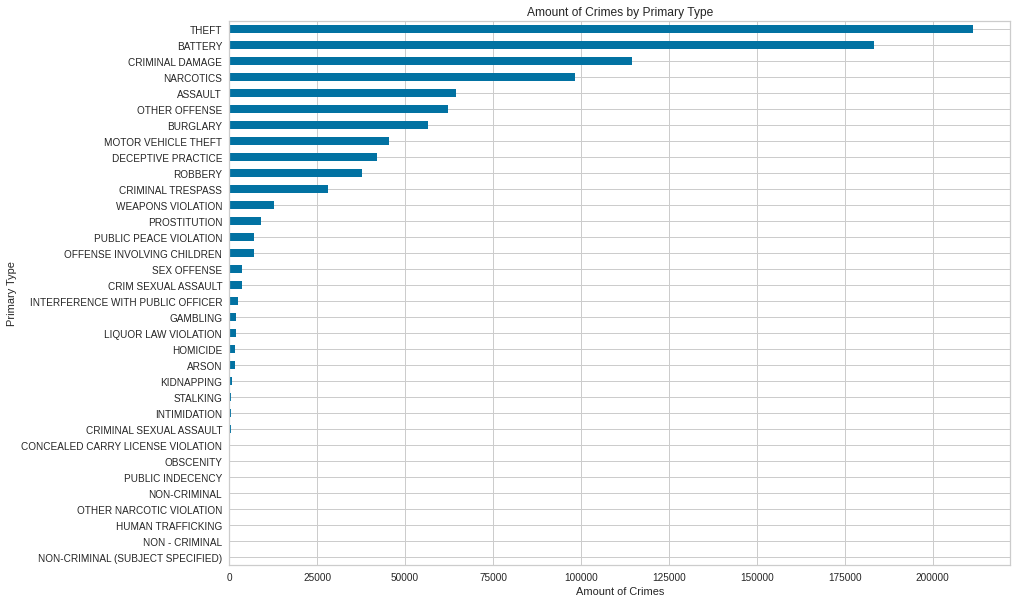

In [ ]:
# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [ ]:
# At previous plot, we could see that the classes is quite imbalance
# Therefore, we are going to group several less occured Crime Type into 'Others' to reduce the Target Class amount

# First, we sum up the amount of Crime Type happened and select the last 13 classes
all_classes = df.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(13)
unwanted_classes

,Primary Type,Amt
11,HOMICIDE,1642
15,KIDNAPPING,830
31,STALKING,595
14,INTIMIDATION,591
7,CRIMINAL SEXUAL ASSAULT,488
4,CONCEALED CARRY LICENSE VIOLATION,118
22,OBSCENITY,93
27,PUBLIC INDECENCY,28
20,NON-CRIMINAL,22
24,OTHER NARCOTIC VIOLATION,16


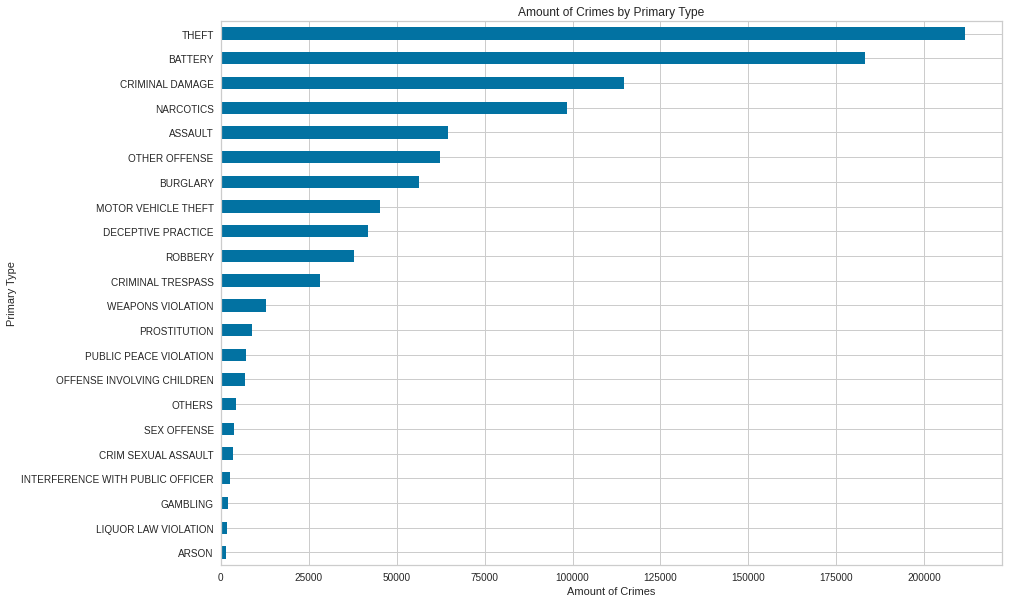

In [ ]:
# After that, we replaced it with label 'OTHERS'
df.loc[df['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [ ]:
# Now we are left with 14 Class as our predictive class
Classes = df['Primary Type'].unique()
Classes

array(['THEFT', 'INTERFERENCE WITH PUBLIC OFFICER', 'CRIMINAL DAMAGE',
       'NARCOTICS', 'BATTERY', 'OTHER OFFENSE', 'ASSAULT',
       'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'OTHERS', 'ROBBERY',
       'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'BURGLARY',
       'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE',
       'PUBLIC PEACE VIOLATION', 'CRIM SEXUAL ASSAULT', 'GAMBLING',
       'ARSON', 'PROSTITUTION', 'LIQUOR LAW VIOLATION'], dtype=object)

In [ ]:
#Encode target labels into categorical variables:
df['Primary Type'] = pd.factorize(df["Primary Type"])[0] 
df['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

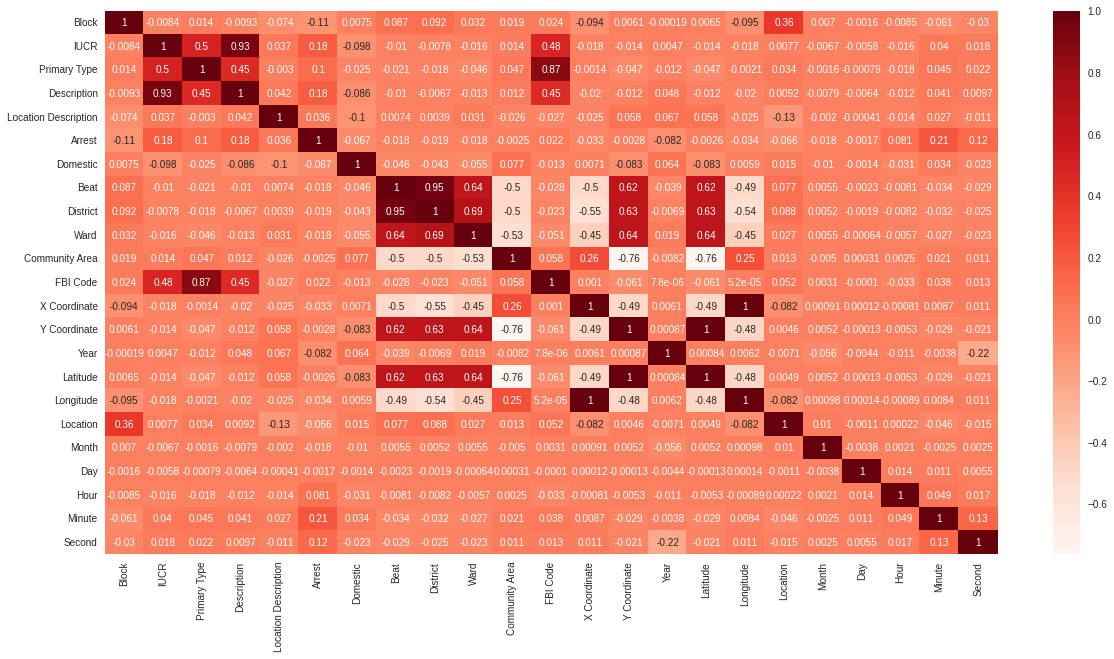

In [ ]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = df.drop(['Primary Type'], axis=1)
Y_fs = df['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor['Primary Type'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

IUCR            0.500662
Primary Type    1.000000
Description     0.450658
Arrest          0.104730
FBI Code        0.865637
Name: Primary Type, dtype: float64

In [ ]:
df.columns

Index(['Block', 'IUCR', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Latitude',
       'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Minute', 'Second'],
      dtype='object')

In [ ]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ['Block', 'IUCR', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'X Coordinate', 'Y Coordinate', 'Year', 'Latitude',
       'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Minute', 'Second']
print('Full Features: ', Features)

Full Features:  ['Block', 'IUCR', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'X Coordinate', 'Y Coordinate', 'Year', 'Latitude', 'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Minute', 'Second']


In [ ]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(df, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['Block', 'IUCR', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'X Coordinate', 'Y Coordinate', 'Year', 'Latitude', 'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Minute', 'Second']
Target Class        :  Primary Type
Training Set Size   :  (800000, 23)
Test Set Size       :  (200000, 23)


In [ ]:
# Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y[Features])

In [ ]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.93072
Recall      :  0.93072
Precision   :  0.9341054817040211
F1 Score    :  0.93072
Confusion Matrix: 
[[41837     0     2    56     3    50    43   166     1     0   182     0
     48   129     0     0     0     0     0     0     1     0]
 [   17   282     1    72     5    38     0    24     5     0    13     4
      1     2     1     0     1     0     6     0    36     4]
 [    8     0 22575    89     4    28     0    68    55     0    90     1
     97     1     0     0     3     0     0     1     0     1]
 [    2     0     0 19503    18    43     1    15     1     0    26     0
      2     9     0     0     6     0     0     0    14    11]
 [    7     0     3   600 34915   171   126   203    36     0   344    17
     21   148    53     1    24     0     0     1     5     8]
 [   23     1    36   380    42 10765     4   352    46     0   289    20
     73   290    38     1     3     0     0     0    20    15]
 [    6     

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


================= Classification Report =================

                                  precision    recall  f1-score   support

                           THEFT       1.00      0.98      0.99     42518
INTERFERENCE WITH PUBLIC OFFICER       0.98      0.55      0.71       512
                 CRIMINAL DAMAGE       1.00      0.98      0.99     23021
                       NARCOTICS       0.85      0.99      0.92     19651
                         BATTERY       0.97      0.95      0.96     36683
                   OTHER OFFENSE       0.88      0.87      0.88     12398
                         ASSAULT       0.96      0.89      0.93     12768
              DECEPTIVE PRACTICE       0.78      0.90      0.83      8461
             MOTOR VEHICLE THEFT       0.96      0.95      0.95      8966
                          OTHERS       0.99      0.26      0.42       877
                         ROBBERY       0.74      0.88      0.80      7674
               WEAPONS VIOLATION       0.95      0.7

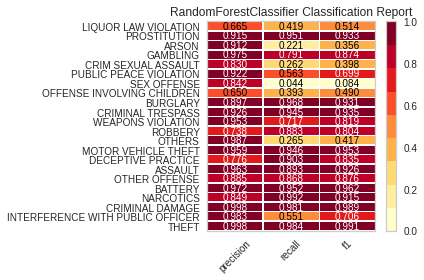

In [ ]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
df.head(1)

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
5969909,0,0,0,0,0,False,False,413,4.0,8.0,47.0,0,1184901.0,1845523.0,2012,41.73127,-87.598225,0,5,3,12,0,0


In [ ]:
actual = df.iloc[200]['Primary Type']
pred = rf_model.predict(np.array(df.iloc[200][Features]).reshape(1,-1))

print(actual, pred)

5 [5]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
xgb_df = df.sample(n=500000)
#Split dataset to Training Set & Test Set
xgb_x, xgb_y = train_test_split(xgb_df, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

xgb_x1 = xgb_x[Features]    #Features to train
xgb_x2 = xgb_x[Target]      #Target Class to train
xgb_y1 = xgb_y[Features]    #Features to test
xgb_y2 = xgb_y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', xgb_x.shape)
print('Test Set Size       : ', xgb_y.shape)

Feature Set Used    :  ['Block', 'IUCR', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'X Coordinate', 'Y Coordinate', 'Year', 'Latitude', 'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Minute', 'Second']
Target Class        :  Primary Type
Training Set Size   :  (400000, 23)
Test Set Size       :  (100000, 23)


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=3)

In [ ]:
# Model Training
xgb_model.fit(X=xgb_x1,
             y=xgb_x2)

# Prediction
result = xgb_model.predict(xgb_y[Features])

In [ ]:
# Model Evaluation
ac_sc = accuracy_score(xgb_y2, result)
rc_sc = recall_score(xgb_y2, result, average="weighted")
pr_sc = precision_score(xgb_y2, result, average="weighted")
f1_sc = f1_score(xgb_y2, result, average='micro')
confusion_m = confusion_matrix(xgb_y2, result)

print("========== XGBoost Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== XGBoost Results ==========
Accuracy    :  0.98318
Recall      :  0.98318
Precision   :  0.9837859386495095
F1 Score    :  0.98318
Confusion Matrix: 
[[21044     0     0     2     0     0     0     7     0     0     5     0
      0     0     2     0     0     0     0     0     0     0]
 [    0   220     0    20     0     0     0     2     0     8     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    0     0 11416     4     0     5     0     5     0     5     0     0
      7     0     0     0     1     0     0     0     0     0]
 [    1     0     0  9819    17    15     0    14     0     1    11     0
      0     0     0     0     1     0     0     0     0     0]
 [    0     0     0   195 18112    18     0    53     2    11    10     0
      0     0    16     0     1     2     0     0     0     0]
 [    0     0     0   173     5  5811     0    94     0     7    17     0
      0     0     7     0     0     0     0     0     0     0]
 [    0     0     

================= Classification Report =================

                                  precision    recall  f1-score   support

                           THEFT       1.00      1.00      1.00     21060
INTERFERENCE WITH PUBLIC OFFICER       1.00      0.88      0.94       250
                 CRIMINAL DAMAGE       1.00      1.00      1.00     11443
                       NARCOTICS       0.92      0.99      0.96      9879
                         BATTERY       0.99      0.98      0.99     18420
                   OTHER OFFENSE       0.98      0.95      0.96      6114
                         ASSAULT       1.00      0.98      0.99      6535
              DECEPTIVE PRACTICE       0.93      0.94      0.94      4121
             MOTOR VEHICLE THEFT       1.00      0.99      0.99      4533
                          OTHERS       0.83      0.86      0.85       456
                         ROBBERY       0.97      0.96      0.96      3818
               WEAPONS VIOLATION       1.00      0.9

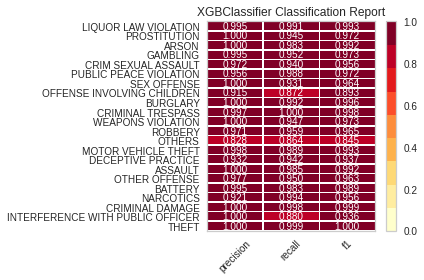

In [ ]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(xgb_model, classes=target_names)
visualizer.fit(X=xgb_x1, y=xgb_x2)     # Fit the training data to the visualizer
visualizer.score(xgb_y1, xgb_y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(xgb_y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

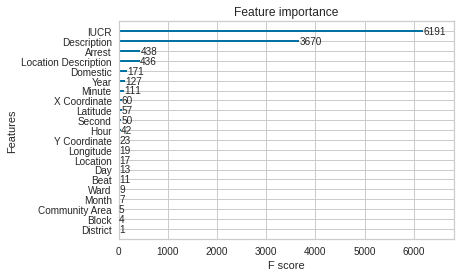

In [ ]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_model)
plt.show()

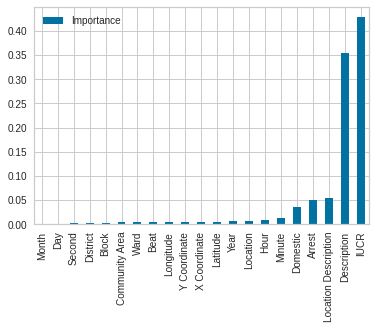

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(Features, rf_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance').plot(kind='bar', rot=90)

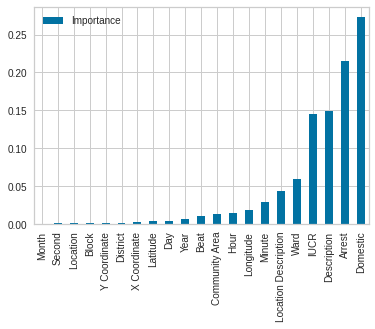

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(Features, xgb_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance').plot(kind='bar', rot=90)

In [ ]:
len(df['Primary Type'].unique())

22